In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import nengo

import numpy as np
import scipy.interpolate
from scipy.interpolate import Rbf, CubicSpline
from rbf.pde.nodes import disperse, poisson_disc_nodes



In [2]:
def generate_linear_trajectory(trajectory, temporal_resolution=1., velocity=30., equilibration_duration=None):
    """
    Construct coordinate arrays for a spatial trajectory, considering run velocity to interpolate at the specified
    temporal resolution. Optionally, the trajectory can be prepended with extra distance traveled for a specified
    network equilibration time, with the intention that the user discards spikes generated during this period before
    analysis.

    :param trajectory: namedtuple
    :param temporal_resolution: float (s)
    :param equilibration_duration: float (s)
    :return: tuple of array
    """
        
    velocity = velocity  # (cm / s)
    spatial_resolution = velocity * temporal_resolution
    x = trajectory[:, 0]
    y = trajectory[:, 1]
    
    if equilibration_duration is not None:
        equilibration_distance = velocity / equilibration_duration
        x = np.insert(x, 0, x[0] - equilibration_distance)
        y = np.insert(y, 0, y[0])
    else:
        equilibration_duration = 0.
        equilibration_distance = 0.
    
    segment_lengths = np.sqrt((np.diff(x) ** 2. + np.diff(y) ** 2.))
    distance = np.insert(np.cumsum(segment_lengths), 0, 0.)
    
    interp_distance = np.arange(distance.min(), distance.max() + spatial_resolution / 2., spatial_resolution)
    interp_x = np.interp(interp_distance, distance, x)
    interp_y = np.interp(interp_distance, distance, y)
    t = interp_distance / velocity  # s
    
    t = np.subtract(t, equilibration_duration)
    interp_distance -= equilibration_distance
    
    return t, interp_x, interp_y, interp_distance




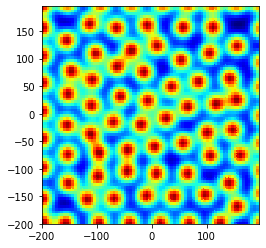

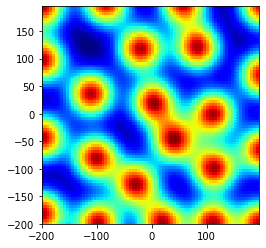

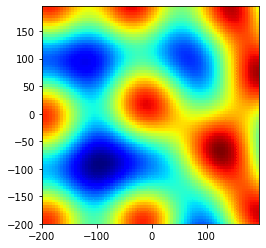

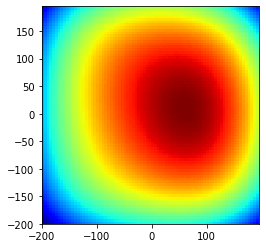

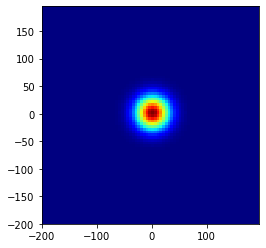

In [3]:
arena_dimension = 200
vert = np.array([[-arena_dimension,-arena_dimension],[-arena_dimension,arena_dimension],
                 [arena_dimension,arena_dimension],[arena_dimension,-arena_dimension]])
smp = np.array([[0,1],[1,2],[2,3],[3,0]])
    
arena_res = 5
arena_x = np.arange(-arena_dimension, arena_dimension, arena_res)
arena_y = np.arange(-arena_dimension, arena_dimension, arena_res)

arena_xx, arena_yy = np.meshgrid(arena_x, arena_y, indexing='ij')
peak_rate = 1.
nmodules = 4

field_width_params = [35.0, 0.32]
field_width        = lambda x: 40. + field_width_params[0] * (np.exp(x / field_width_params[1]) - 1.)

module_field_width        = [field_width( float(i) / float(nmodules) ) for i in range(nmodules)]
    
input_nodes_dict = {}
input_groups_dict = {}
input_rates_dict = {}

for m in range(nmodules):
   nodes, groups, _ = poisson_disc_nodes(module_field_width[m], (vert, smp))
   input_groups_dict[m] = groups
   input_nodes_dict[m] = nodes
   input_rates_dict[m] = {}
        
   for i in range(nodes.shape[0]):
           
       x_obs = np.asarray([nodes[i,0], nodes[i,1]]).reshape((1,-1))
       u_obs = np.asarray([[peak_rate]]).reshape((1,-1))
       input_rate_ip  = Rbf(x_obs[:,0], x_obs[:,1], u_obs, function='gaussian', 
                            epsilon=module_field_width[m] / 2.)
       input_rates_dict[m][i] = input_rate_ip
       
input_rate_maps = []
for m in range(nmodules):
    for i in range(len(input_rates_dict[m])):
        input_rates = input_rates_dict[m][i](arena_xx, arena_yy)
        input_rate_maps.append(input_rates.ravel())
input_rate_matrix = np.column_stack(input_rate_maps)
    
    
target_field_width = 80.
target_field_x = 0.
target_field_y = 0.

x_obs = np.asarray([target_field_x, target_field_y]).reshape((1,-1))
u_obs = np.asarray([[peak_rate]]).reshape((1,-1))
target_rate_ip  = Rbf(x_obs[:,0], x_obs[:,1], u_obs, function='gaussian', 
                      epsilon=target_field_width/2.71828)
target_rate_map = target_rate_ip(arena_xx, arena_yy)


for m in range(nmodules):
        plt.figure()
        arena_map = np.zeros(arena_xx.shape)
        for i in range(len(input_rates_dict[m])):
            input_rates = input_rates_dict[m][i](arena_xx, arena_yy)
            arena_map += input_rates
        plt.pcolor(arena_xx, arena_yy, arena_map, cmap=cm.jet)
        ax = plt.gca()
        ax.set_aspect('equal')
        
plt.figure()
plt.pcolor(arena_xx, arena_yy, target_rate_map, cmap=cm.jet)
ax = plt.gca()
ax.set_aspect('equal')


In [4]:
diag_trajectory = np.asarray([[-100, -100], [100, 100]])
trj_t, trj_x, trj_y, trj_d = generate_linear_trajectory(diag_trajectory, temporal_resolution=0.001)
    
trajectory_input_rates = { m: {} for m in range(nmodules) }
all_trajectory_inputs = []
    
for m in trajectory_input_rates:
        for i in input_rates_dict[m]:
                input_rates = input_rates_dict[m][i](trj_x, trj_y)
                trajectory_input_rates[m][i] = input_rates
                input_rates_ip = CubicSpline(trj_t, input_rates)
                all_trajectory_inputs.append(input_rates_ip)
            
        target_trajectory_rates = target_rate_ip(trj_x, trj_y)
    
        N_PF_Ext = len(all_trajectory_inputs)
        print(N_PF_Ext)


83
105
115
125


In [6]:
def trajectory_input(t):
        result = np.asarray([ 2.*y(t) - 1. for y in all_trajectory_inputs ])
        return result
    
    
    
X_train = 2.*input_rate_matrix - 1.
y_train = target_rate_map.reshape((-1,1))
    
X_test = trajectory_input(trj_t).T
y_test = target_trajectory_rates.ravel()
    
    
n_features = X_train.shape[1]
n_output = y_train.shape[1]

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

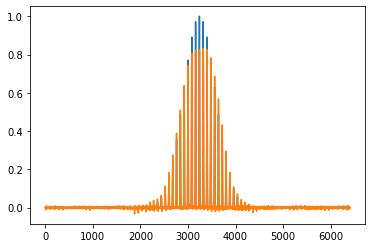

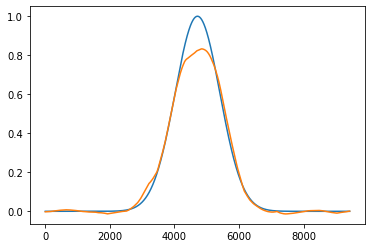

In [7]:
from nengo.utils.least_squares_solvers import LSMRScipy
solver = nengo.solvers.LstsqL2nz(reg=0.01, )
        
ens_params = dict(
        max_rates=nengo.dists.Choice([20.]),
        intercepts=nengo.dists.Choice([0.1]),
        
)
        
with nengo.Network(seed=19, label="Receptive field tuning") as tuning_model:
           
        
        tuning_model.PC = nengo.Ensemble(n_neurons=5000, dimensions=n_features, 
                                         neuron_type=nengo.RectifiedLinear(),
                                         eval_points=X_train,
                                         **ens_params)                                
        
        tuning_model.output = nengo.Ensemble(n_neurons=1, dimensions=1,
                                             neuron_type=nengo.LIF(),
                                             **ens_params)
                                             
                                       
        PC_to_output = nengo.Connection(tuning_model.PC, 
                                        tuning_model.output.neurons, 
                                        synapse=nengo.Lowpass(0.05),
                                        eval_points=X_train, 
                                        function=y_train,
                                        solver=solver)
    
    
tuning_sim = nengo.Simulator(tuning_model)
output_weights = tuning_sim.data[PC_to_output].weights
    
_, train_acts = nengo.utils.ensemble.tuning_curves(tuning_model.PC, tuning_sim, inputs=X_train)
_, test_acts = nengo.utils.ensemble.tuning_curves(tuning_model.PC, tuning_sim, inputs=X_test)
    
    

plt.figure()
plt.plot(y_train)
plt.plot(np.dot(train_acts, output_weights.T))
    
plt.figure()
plt.plot(y_test)
plt.plot(np.dot(test_acts, output_weights.T))



In [8]:
def get_outs(sim, inputs):
        # encode the inputs to get the ensemble activations
        _, acts = nengo.utils.ensemble.tuning_curves(tuning_model.PC, sim, inputs=inputs)
        # decode the ensemble activities using the connection's decoders
        return np.dot(acts, sim.data[PC_to_output].weights.T)
    
    
def get_error(sim, inputs, target):
        # the classification for each example is index of
        # the output dimension with the highest value
        res = get_outs(sim, inputs) - target
        return res
    
def print_error(sim):
        train_error = np.square(get_error(sim, X_train, y_train)).mean()
        test_error = np.square(get_error(sim, X_test, y_test)).mean()
        
        print("Mean squared training error: %f" % (train_error,))
        print("Mean squared testing error: %f" % (test_error,))
        
with nengo.Simulator(tuning_model) as tuning_sim:
        print_error(tuning_sim)



HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

Mean squared training error: 0.000138
Mean squared testing error: 0.176470


In [9]:
def make_basic_srf_model(N_Exc, weights, encoders):
        with nengo.Network(label="Basic spatial receptive field model", seed=19) as model:
    
            model.Input = nengo.Node(trajectory_input, size_out=X_train.shape[1])
                                         
            model.Exc = nengo.Ensemble(N_Exc, dimensions=X_train.shape[1], 
                                       neuron_type=nengo.RectifiedLinear(),
                                       intercepts=nengo.dists.Choice([0.1]),
                                       max_rates=nengo.dists.Choice([20]),
                                       encoders=encoders)
            model.Output = nengo.Ensemble(1, dimensions=1,
                                          neuron_type=nengo.LIF(),
                                          intercepts=nengo.dists.Choice([0.1]),
                                          max_rates=nengo.dists.Choice([40]))
                                      
            nengo.Connection(model.Input, model.Exc, synapse=nengo.Alpha(0.01))
            nengo.Connection(model.Exc.neurons, model.Output, 
                             transform=weights, synapse=nengo.Lowpass(0.05))
                             
            return model

network_weights = tuning_sim.data[PC_to_output].weights
network_encoders = tuning_sim.data[tuning_model.PC].encoders        
        
basic_srf_model = make_basic_srf_model(5000, network_weights, network_encoders)

with basic_srf_model:
        Exc_probe = nengo.Probe(basic_srf_model.Exc, synapse=0.01)
        Output_probe = nengo.Probe(basic_srf_model.Output, synapse=0.01)
        Output_v_probe = nengo.Probe(basic_srf_model.Output.neurons, 'voltage')
        
with nengo.Simulator(basic_srf_model) as sim:
        sim.run(np.max(trj_t))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<Figure size 1080x576 with 0 Axes>

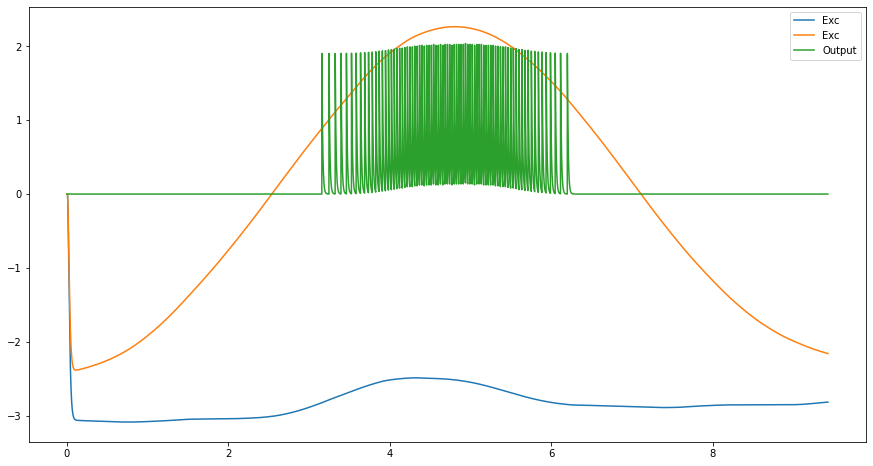

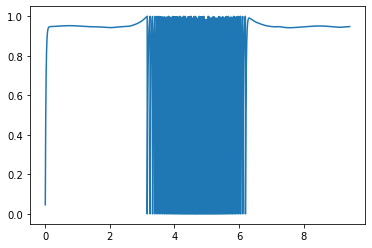

In [10]:
plt.figure(figsize=(15,8))
plt.figure(figsize=(15,8))
plt.plot(sim.trange(), sim.data[Exc_probe][:,104:106], label='Exc')
plt.plot(sim.trange(), sim.data[Output_probe], label='Output')
plt.legend();

plt.figure()
plt.plot(sim.trange(), sim.data[Output_v_probe], label='Output v')

In [ ]:
def make_circuit_model(N_Exc, N_Inh, ndim):
        
        with nengo.Network(label="Basic receptive field circuit model") as model:
    
            model.input = nengo.Node([0])
            model.Exc = nengo.Ensemble(N_Exc, dimensions=ndim)
            model.Inh = nengo.Ensemble(N_Inh, dimensions=ndim)
            
            nengo.Connection(model.input, model.Exc)
       
            
            wscale = 0.00001        
    
            p_Exc_to_Inh = 0.15
            p_Inh_to_Inh = 0.15
            p_Inh_to_Exc = 0.3
            p_Exc_to_Exc = 0.01
            
            model.Exc_to_Inh = np.where(np.random.uniform(0, 1, size=(N_Inh, N_Exc))<=p_Exc_to_Inh, 
                                        np.random.uniform(0, 2*wscale, size=(N_Inh,N_Exc)), 0.)
            nengo.Connection(model.Exc.neurons, model.Inh.neurons,
                            transform=model.Exc_to_Inh,
                            synapse=nengo.Alpha(0.006))
    
            model.Inh_to_Inh = np.where(np.random.uniform(0, 1, size=(N_Inh, N_Inh))<=p_Inh_to_Inh,
                                        np.random.uniform(0, -2*wscale, size=(N_Inh, N_Inh)), 0.)
            nengo.Connection(model.Inh.neurons, model.Inh.neurons,
                            transform=model.Inh_to_Inh,
                            synapse=nengo.Alpha(0.006))
        
            model.Inh_to_Exc = np.where(np.random.uniform(0, 1, size=(N_Exc, N_Inh))<=p_Inh_to_Exc,
                                        np.random.uniform(0, -2*wscale, size=(N_Exc, N_Inh)), 0.)
            nengo.Connection(model.Inh.neurons, model.Exc.neurons,
                            transform=model.Inh_to_Exc,
                            synapse=nengo.Alpha(0.006))
    
            model.Exc_to_Exc = np.where(np.random.uniform(0, 1, size=(N_Exc, N_Exc))<=p_Exc_to_Exc, 
                               np.random.uniform(0, 10*wscale, size=(N_Exc, N_Exc)), 0)
        
            nengo.Connection(model.Exc.neurons, model.Exc.neurons,
                            transform=model.Exc_to_Exc,
                            synapse=nengo.Alpha(0.006))
            
            return model
